In [1]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()


import shapely
import shapely.vectorized

from scoping.models import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import product, combinations
from utils.text import *
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy
import geopy
import geopy.distance

import cartopy.io.shapereader as shpreader


import pandas as pd

In [2]:
df = pd.read_csv('../data/category_predictions.csv')
df.head()

,Unnamed: 0,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,6 - Water availability - k_prediction,6 - Water availability - k_prediction_binary,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1284614,Tree-ring width chronologies from the upper ti...,Separating temperature from precipitation sign...,Northeastern Tibetan Plateau; Tree-ring width;...,"['Geography, Physical; Geosciences, Multidisci...",0.0,0.0,0.0,0.0,...,NaN,NaN,1.000000,0.000000,1.0,1.000000,0.333333,0.471405,0.0,0.804738
2,2,1344242,This study examines the spatial and temporal p...,GIS analysis of spatial and temporal patterns ...,fire; geographic information systems; manageme...,['Forestry'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,289649,"Permafrost, mainly of discontinuous type, that...","Thermokarst lake, hydrological flow and water ...",Permafrost; Thermokarst lakes; Hydrological cy...,"['Engineering, Civil; Geosciences, Multidiscip...",0.0,0.0,0.0,0.0,...,NaN,NaN,0.166667,0.372678,0.0,0.539345,1.000000,0.000000,1.0,1.000000
4,4,399966,"Since 2005, Morocco has designated 28 Importan...",Factors Influencing Species-Richness of Breedi...,Breeding waterfowl; Diversity; Spatial scale; ...,['Ecology; Environmental Sciences'],0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
geos = pd.read_csv('../data/geo_df.csv')
geos = geos.drop_duplicates(["doc_id","geonameid"])
print(geos.shape)
geos.head()

(105576, 9)


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id
0,NaN,39.76000,-98.5000,USA,6252001,United States,A,PCLI,3305893
1,NaN,22.00000,79.0000,IND,1269750,Republic of India,A,PCLI,1477550
2,NaN,60.00000,100.0000,RUS,2017370,Russian Federation,A,PCLI,1477550
3,Punjab,31.47060,74.3488,PAK,7043356,Pakistan Foundation Technical Institute,S,SCHC,1477550
4,NaN,3.51342,-132.1875,NaN,2363254,Pacific Ocean,H,OCN,1477550


In [4]:
from operator import itemgetter
import ast

places = pd.read_csv('../data/place_df.csv')
places = places[places['country_conf']>0.8]
places = places[pd.notnull(places["geo"])]
def extract_geo(df,l):
    return zip(*[itemgetter(*l)(ast.literal_eval(x.replace("nan",'""'))) for x in places.geo])
places['lat'], places['lon'], places['feature_code'] = extract_geo(places, ["lat","lon","feature_code"])
places.lat = places.lat.astype(float)
places.lon = places.lon.astype(float)
#places = places[places["feature_code"]!="PCLI"]
places.head()

,Unnamed: 0,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code
0,0,United States,"[{'start': 427, 'end': 440}]",USA,0.999811,"{'admin1': 'NA', 'lat': '39.76', 'lon': '-98.5...",3305893,39.7600,-98.5000,PCLI
3,3,India,"[{'start': 140, 'end': 145}]",IND,0.999398,"{'admin1': 'NA', 'lat': '22', 'lon': '79', 'co...",1477550,22.0000,79.0000,PCLI
4,4,Russia,"[{'start': 697, 'end': 703}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.0000,100.0000,PCLI
5,5,Pakistan,"[{'start': 763, 'end': 771}]",PAK,0.989610,"{'admin1': 'Punjab', 'lat': '31.4706', 'lon': ...",1477550,31.4706,74.3488,SCHC
7,7,Russia,"[{'start': 983, 'end': 989}]",RUS,0.999401,"{'admin1': 'NA', 'lat': '60', 'lon': '100', 'c...",1477550,60.0000,100.0000,PCLI


In [5]:
df_places = pd.merge(df,places,left_on="id",right_on="doc_id")
df_places.head()

,Unnamed: 0_x,id,content,title,wosarticle__de,wosarticle__wc,ar5,seen,relevant,12 - Coastal and marine Ecosystems,...,Unnamed: 0_y,word,spans,country_predicted,country_conf,geo,doc_id,lat,lon,feature_code
0,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86174,China,"[{'start': 157, 'end': 162}]",CHN,0.999764,"{'admin1': 'NA', 'lat': '35', 'lon': '105', 'c...",136746,35.00,105.00,PCLI
1,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86175,Qinghai,"[{'start': 1777, 'end': 1784}]",CHN,0.993103,"{'admin1': 'Qinghai', 'lat': '36', 'lon': '96'...",136746,36.00,96.00,ADM1
2,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86176,Inner Mongolia,"[{'start': 1786, 'end': 1800}]",CHN,0.993103,"{'admin1': 'Inner Mongolia', 'lat': '43.5', 'l...",136746,43.50,114.75,ADM1
3,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86177,Xinjiang,"[{'start': 1806, 'end': 1814}]",CHN,0.993103,{'admin1': 'Xinjiang Uyghur Autonomous Region'...,136746,41.50,85.50,ADM1
4,0,136746,"Grasslands, one of the most widespread land co...",Dynamic of grassland vegetation degradation an...,Grassland degradation; Climate change; Human i...,['Ecology'],0.0,0.0,0.0,0.0,...,86178,Gansu,"[{'start': 1922, 'end': 1927}]",CHN,0.993103,"{'admin1': 'Gansu', 'lat': '37.75', 'lon': '10...",136746,37.75,102.75,ADM1


# density

In [6]:

def new_haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1[:,None]

    dlat = lat2 - lat1[:,None]

    a = np.sin(dlat/2.0)**2 + np.cos(lat1[:,None]) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def density_grid(degrees,distance,df):
    
    df_countries = df[df["feature_code"]=="PCLI"]
    df_places = df[df["feature_code"]!="PCLI"]

    distance = 100

    latbins = np.linspace(-90,90, round(180/degrees))
    lonbins = np.linspace(-180,180, round(360/degrees))

    n = np.zeros((len(latbins),len(lonbins)))
    
    print(f"calculating density grid of size: {n.size}")

    for i,lat in enumerate(latbins):
        r = geopy.distance.distance(kilometers=distance)
        latp = geopy.Point((lat,135))
        # if the latitude is closer than distance to the north pole, then the northern bound should be 
        # the north pole, not distancekm north of the latitude (which will pass the pole and go south again)
        if geopy.distance.great_circle(latp,(90,135)).km < distance:
            r_nbound = 90   
        else:
            r_nbound = r.destination(point=latp,bearing=0).latitude
        # Same as above for the south pole
        if geopy.distance.great_circle(latp,(-90,135)).km < distance:
            r_sbound = -90   
        else:
            r_sbound = r.destination(point=latp,bearing=180).latitude        

        latbound_df = df_places[
            (df_places.lat>=r_sbound) &
            (df_places.lat<=r_nbound)        
        ]

        ds = new_haversine_np(latbound_df['lon'], latbound_df['lat'],lonbins,[lat]*len(lonbins))

        n[i,:] = np.where(ds<distance,1,0).sum(axis=0)
        
    print("done")
    
    shpfilename = shpreader.natural_earth(resolution='110m',
                                          category='cultural',
                                          name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    yv, xv = np.meshgrid(latbins, lonbins)

    for country in reader.records():
        incountry = shapely.vectorized.contains(country.geometry,xv,yv)
        idx = np.argwhere(incountry==True)
        ndots = idx.size/2
        cdf = df_countries[df_countries["country_predicted"]==country.attributes["SU_A3"]]
        for point in idx:
            n[point[1],point[0]] += cdf.shape[0]/ndots


        
    return latbins, lonbins, n

latbins, lonbins, n = density_grid(0.5,100,df_places)

calculating density grid of size: 259200
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


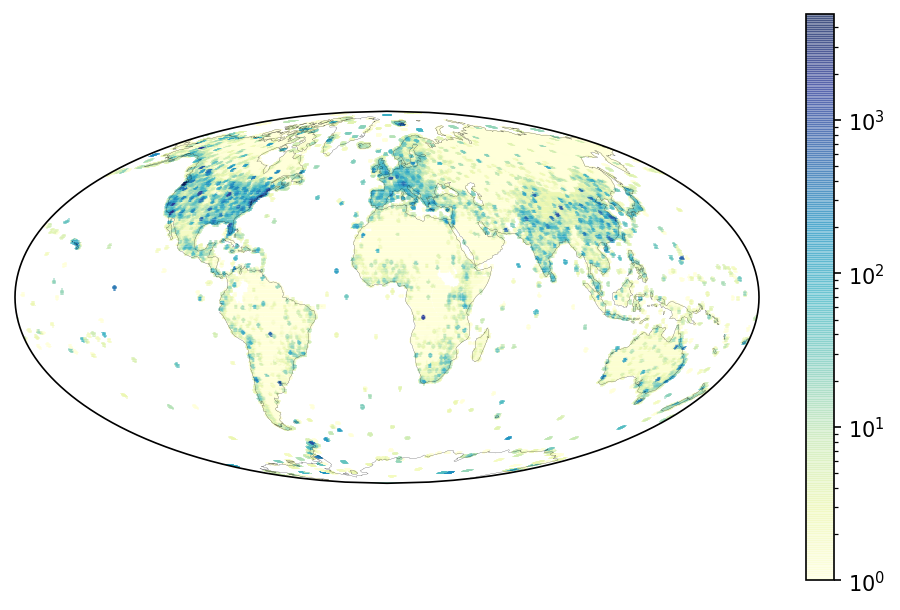

In [8]:
fig, ax = plt.subplots(dpi=150, figsize=(8,5))

p = ccrs.Mollweide()
#p = ccrs.PlateCarree()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

fig.colorbar(pcm)

In [10]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - mean_prediction" in c]

for c in pred_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
print(pred_cats)

attrib_cats = [c for c  in df.columns if "2 - " in c and " - mean_prediction" in c and not "12 - " in c]
for c in attrib_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
attrib_cats

driver_cats = [c for c  in df.columns if "6 - " in c and " - mean_prediction" in c ]
for c in driver_cats:
    print(df[c].sum())
    label = c.replace(" - mean_prediction",'')
    df.loc[df[label]==1,c] = 1
    print(df[c].sum())
driver_cats

2135.833333333333
2135.833333333333
7977.833333333335
7977.833333333335
3682.3333333333335
3682.3333333333335
28527.000000000004
28527.000000000004
6409.000000000001
6409.000000000001
['12 - Mountains, snow and ice - mean_prediction', '12 - Rivers, lakes, and soil moisture - mean_prediction', '12 - Coastal and marine Ecosystems - mean_prediction', '12 - Terrestrial ES - mean_prediction', '12 - Human and managed - mean_prediction']
37444.333333333336
37444.333333333336
26536.166666666664
26536.166666666664
1975.0000000000002
1975.0000000000002
12054.5
12054.5
3966.0
3966.0


['6 - Temperature - mean_prediction', '6 - Precipitation - mean_prediction']

calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


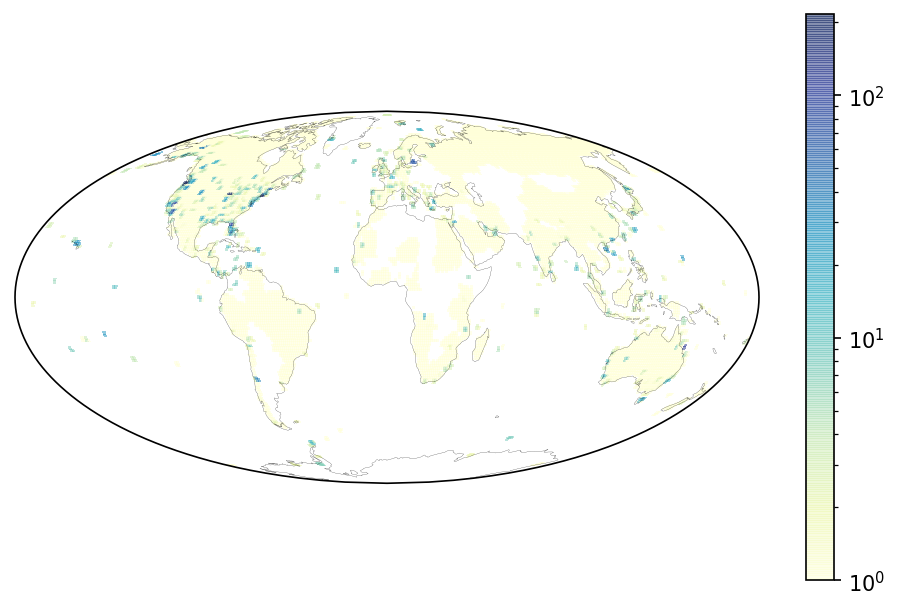

In [11]:
fig, ax = plt.subplots(dpi=150, figsize=(8,5))

sdf = df_places[df_places['12 - Coastal and marine Ecosystems - mean_prediction']>0.5]

latbins, lonbins, n = density_grid(1,100,sdf)


p = ccrs.Mollweide()
#p = ccrs.PlateCarree()

ax = plt.axes(projection=p)
ax.set_global()
ax.coastlines(lw=0.1)

vm = n[~np.isnan(n)].max()

n[n == 0] = np.nan

pcm = plt.pcolormesh( 
    lonbins, latbins, n,
    transform=ccrs.PlateCarree(),
    norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
    alpha=0.5,
    cmap="YlGnBu"
)

fig.colorbar(pcm)

In [12]:
pred_cats


['12 - Mountains, snow and ice - mean_prediction',
 '12 - Rivers, lakes, and soil moisture - mean_prediction',
 '12 - Coastal and marine Ecosystems - mean_prediction',
 '12 - Terrestrial ES - mean_prediction',
 '12 - Human and managed - mean_prediction']

calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


calculating density grid of size: 64800
done


/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


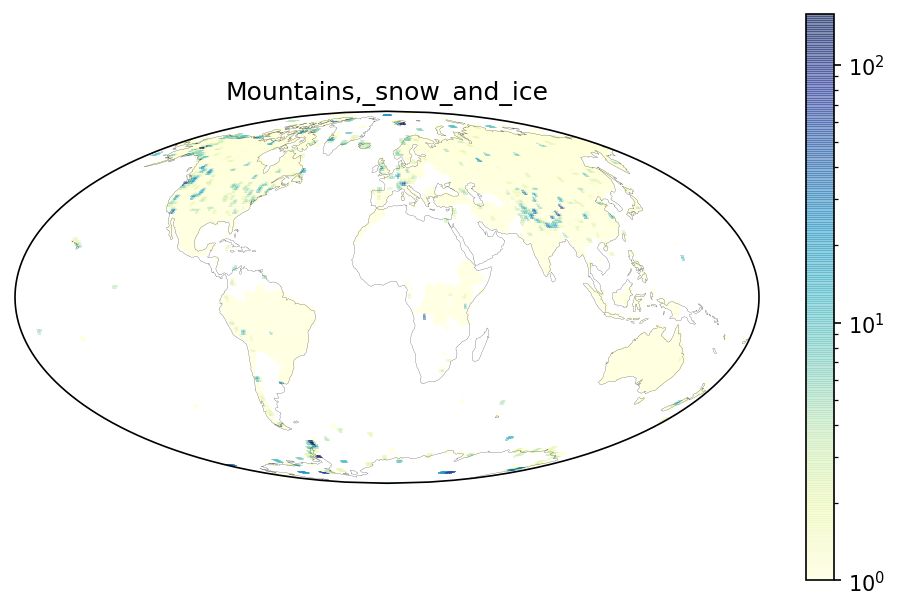

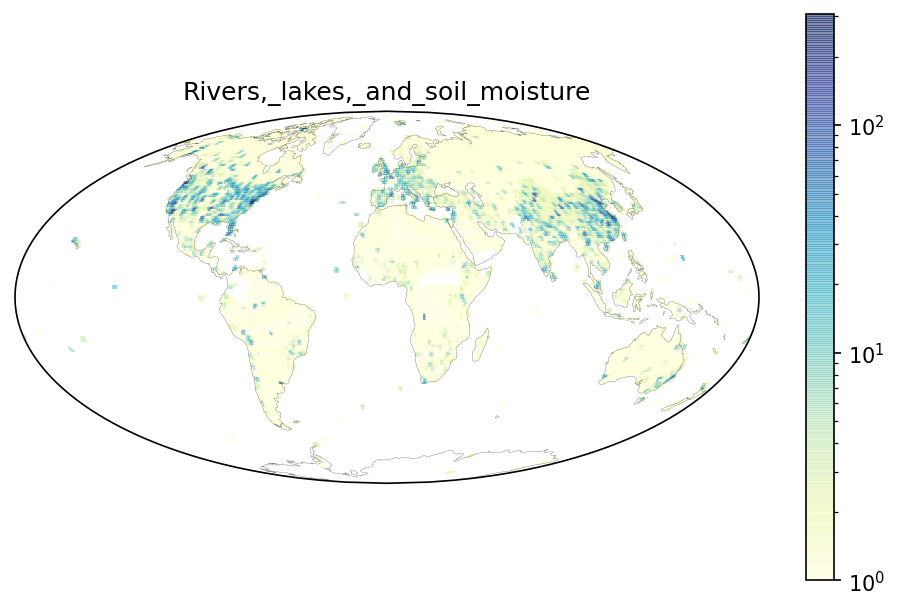

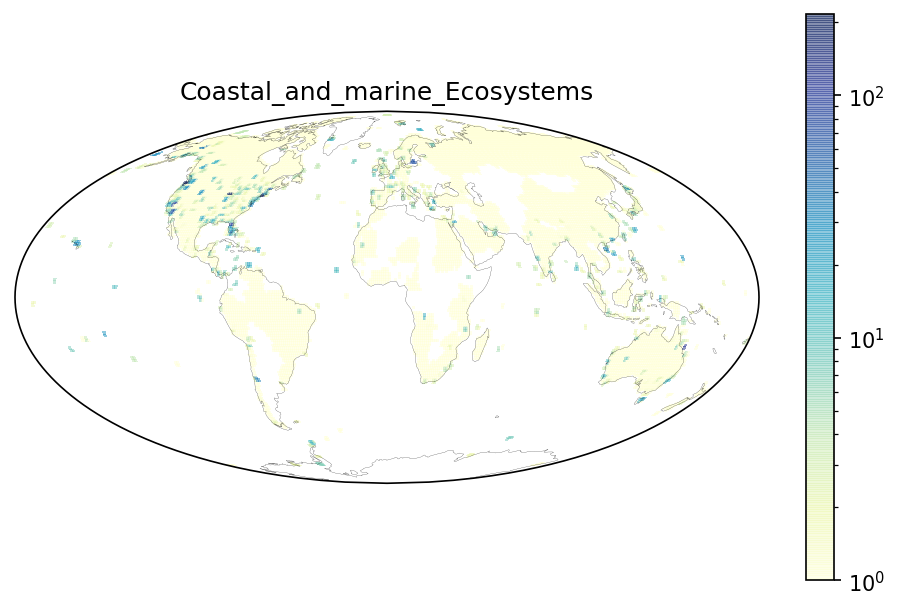

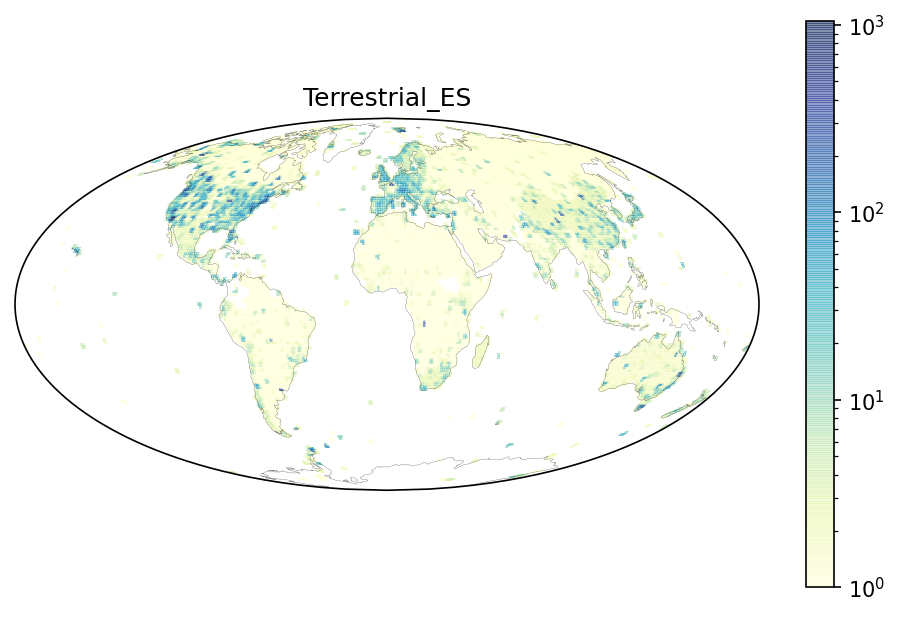

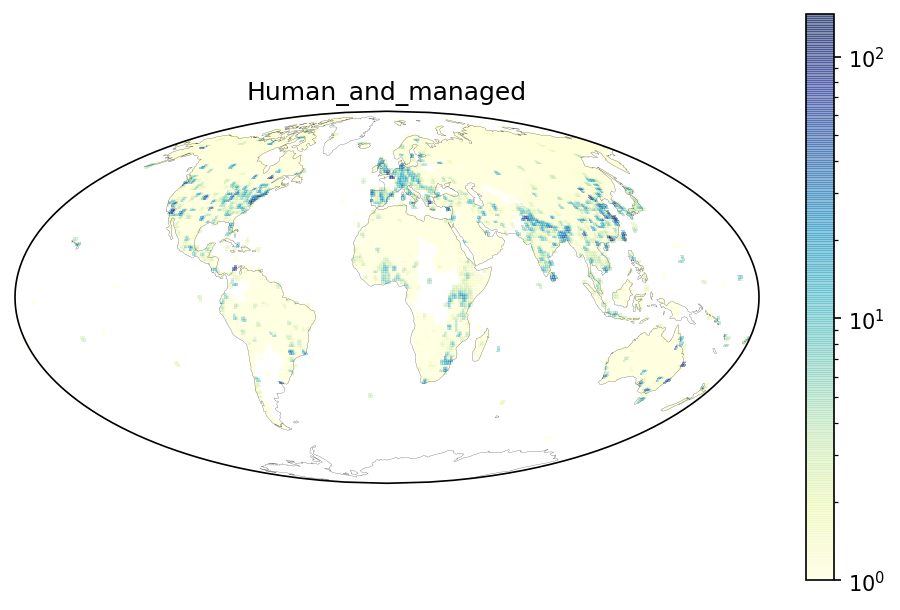

In [14]:
for c in pred_cats:
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))

    sdf = df_places[df_places[c]>0.5]

    latbins, lonbins, n = density_grid(1,100,sdf)


    p = ccrs.Mollweide()
    #p = ccrs.PlateCarree()

    ax = plt.axes(projection=p)
    ax.set_global()
    ax.coastlines(lw=0.1)

    vm = n[~np.isnan(n)].max()

    n[n == 0] = np.nan

    pcm = plt.pcolormesh( 
        lonbins, latbins, n,
        transform=ccrs.PlateCarree(),
        norm=mpl.colors.LogNorm(vmin=1, vmax=vm),
        alpha=0.5,
        cmap="YlGnBu"
    )
    
    cname = c.split(' - ')[1].replace(" ","_")
    plt.savefig(f'../plots/maps/predicted_places_{cname}_density.png',dpi=500)
    plt.savefig(f'../plots/maps/predicted_places_{cname}_density.pdf')
    
    ax.set_title(cname)

    fig.colorbar(pcm)    

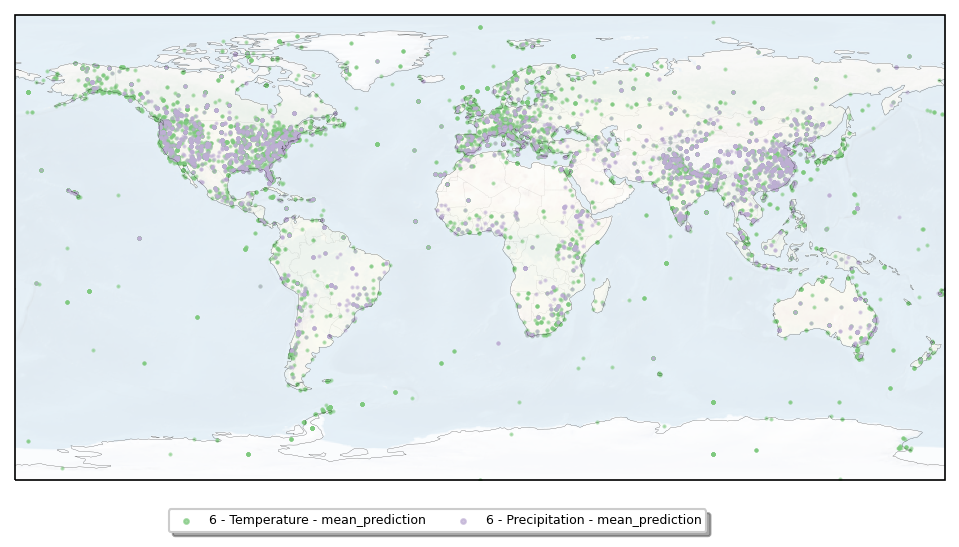

In [16]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - prediction" in c]

colors = ['#7fc97f','#beaed4','#fdc086']

pdf = df_places[df_places['feature_code']!="PCLI"]

fig, ax = plt.subplots(dpi=150, figsize=(8,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.1)
ax.stock_img(alpha=0.2)
ax.set_global()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',lw=0.05)

for i,c in enumerate(driver_cats):
    col = colors[i]
    ax.scatter(pdf[pdf[c]>=0.5]['lon'], pdf[pdf[c]>=0.5]['lat'],alpha=0.5,s=1,label=None,c=col)
    ax.scatter([],[],alpha=0.7,s=5,label=c,c=col)

    
ax.legend(fontsize=6, bbox_to_anchor=(0.75,-0.05),ncol=2, fancybox=True,shadow=True)

plt.savefig(f'../plots/maps/predicted_places_drivers_attribution.png',dpi=500)
plt.savefig(f'../plots/maps/predicted_places_drivers_attribution.pdf')

In [ ]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - prediction" in c]

colors = ['#7fc97f','#beaed4','#fdc086']

pdf = df_geo[df_geo['feature_code']!="PCLI"]

for i,c in enumerate(attrib_cats):
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.stock_img(alpha=0.2)
    ax.set_global()
    ax.set_title(c)
    col = colors[i]
    ax.scatter(pdf[pdf[c]>=0.5]['lon'], pdf[pdf[c]>=0.5]['lat'],alpha=0.2,s=1,label=None,c=col)

    
ax.legend(fontsize=6)

In [ ]:
pred_cats = [c for c  in df.columns if "12 - " in c and " - prediction" in c]
fig, ax = plt.subplots(dpi=150, figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.1)
ax.stock_img(alpha=0.5)
ax.set_global()
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
for j, pdf in enumerate(np.array_split(df_geo,5)):
    for i,c in enumerate(pred_cats):
        #pdf = pdf[pdf[c]>0.5]
        col = colors[i]
        ax.scatter(pdf[pdf[c]>0.5]['lon'], pdf[pdf[c]>0.5]['lat'],alpha=0.05,s=0.5,label=None,c=col)
        if j==0:
            ax.scatter([],[],alpha=0.5,label=c,c=col)
    
ax.legend(fontsize=6)

In [ ]:
pred_cats = [c for c  in df.columns if "12 - " in c and "mean" in c]
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

pdf = df_geo[df_geo['feature_code']!="PCLI"]

for i,c in enumerate(pred_cats):
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.stock_img(alpha=0.5)
    ax.set_global()
    ax.set_title(c)
    col = colors[i]
    ax.scatter(pdf[pdf[c]>0.5]['lon'], pdf[pdf[c]>0.5]['lat'],alpha=0.2,s=1,label=None,c=col)
    if j==0:
        ax.scatter([],[],alpha=0.2,label=c,c=col)
    
ax.legend(fontsize=6)

In [ ]:
c.split(' - ')[1].replace("_","")

In [ ]:
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
colors = ['#7fc97f','#beaed4','#fdc086']
pdf = df_geo[df_geo['feature_code']!="PCLI"]
import cartopy

for i,c in enumerate(pred_cats):
    fig, ax = plt.subplots(dpi=150, figsize=(8,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(lw=0.1)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':',lw=0.05)
    ax.stock_img(alpha=0.2)
    ax.set_global()
    ax.set_title(c)
    for j, ac in enumerate(attrib_cats):
        col = colors[j]
        ax.scatter(
            pdf[(pdf[c]>=0.5)&(pdf[ac]>0.5)]['lon'], pdf[(pdf[c]>=0.5)&(pdf[ac]>0.5)]['lat'],
            alpha=0.5,s=2,label=None,c=col,edgecolor="grey",linewidth=0.5)
        ax.scatter([],[],alpha=0.5,label=ac,c=col)
    
    ax.legend(fontsize=6, bbox_to_anchor=(1,-0.05),ncol=2, fancybox=True,shadow=True)
    cname = c.split(' - ')[1].replace(" ","_")
    plt.savefig(f'../plots/maps/predicted_places_{cname}_attribution.png',dpi=500)
    plt.savefig(f'../plots/maps/predicted_places_{cname}_attribution.pdf')

In [ ]:
us_coastal = df_geo[
    (df_geo['12 - Coastal and marine Ecosystems - prediction']==1) &
    (df_geo['lat']<51) &
    (df_geo['lat']>34) &
    (df_geo['lon']>-117) &
    (df_geo['lon']<-84)
]
us_coastal.shape
for i, row in us_coastal.groupby('geonameid'):
    if row.shape[0]<2:
        continue
    print(row['title'])
    print(row['place_name'])
    print(row['id'])

In [ ]:

for i, row in df_places[df_places['id']==265589].reset_index(drop=True).iterrows():
    if i==0:
        print(row['content'])
    print("word in text: ",row['word'])
    print(row['geo'])
    print(row['country_predicted'])